In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
#import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano
from sklearn import preprocessing
import re

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path_sim = "/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n5500_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path = '/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# PyMC 

## ADVI

In [2]:
#df_sim = pd.read_csv(df_path_sim)
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)

In [9]:
model = sfp.monte_carlo.setup_model(df_sim)

In [10]:
with model:
    advi=pm.ADVI()
    advi_fit = advi.fit(10000, obj_optimizer=pm.adam(learning_rate=.01), )#more_replacements=map_tensor_batch,)# callbacks=[tracker])

Average Loss = -5,401.4: 100%|██████████| 10000/10000 [00:05<00:00, 1704.01it/s]
Finished [100%]: Average Loss = -5,401.4


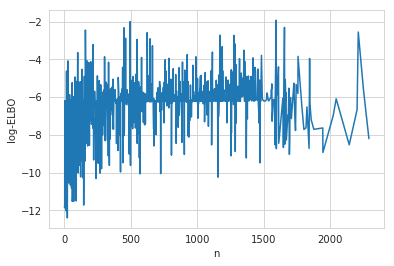

In [11]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [12]:
advi_trace = advi_fit.sample(500)

In [13]:
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
voxel_norm,0.259179,0.004831,0.000194,0.249980,0.269167
sigma,0.995364,0.018782,0.000757,0.951151,1.026065
sf_ecc_slope,0.509445,0.008101,0.000373,0.492128,0.523162
sf_ecc_intercept,0.448265,0.028002,0.001332,0.394971,0.500991


/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


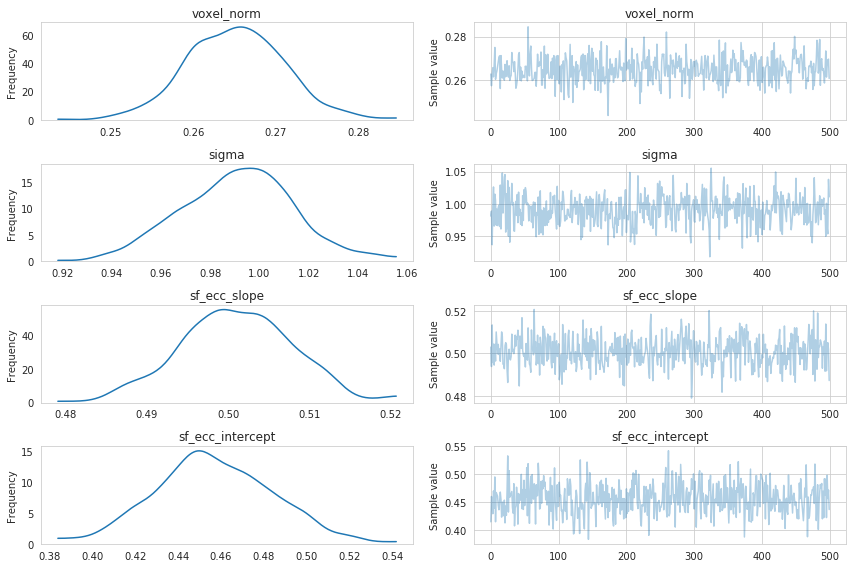

In [157]:
pm.traceplot(advi_trace);#, ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']);

## MCMC

In [ ]:
df_paths = ['/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj001/ses-01/sub-wlsubj001_ses-01_task-sfp_v1_e1-12_summary.csv',
            '/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-03/sub-wlsubj045_ses-03_task-sfp_v1_e1-12_summary.csv']
subjects = ['sub-wlsubj001', 'sub-wlsubj045']
sessions = ['ses-01', 'ses-03']
tasks = ['task-sfp', 'task-sfp']
sigmas = [1, 1.5]
slopes = [.1, .2]
intercepts = [.3, .5]
df_sim = []
for i, (subj, ses, task, s, a, b, noise) in enumerate(zip(subjects, sessions, tasks, sigmas, slopes, intercepts, df_paths)):
    tmp = sfp.simulate_data.main('iso', 'full', False, sigma=s, sf_ecc_intercept=b, sf_ecc_slope=a, num_voxels=100, noise_source_path=noise, noise_level=1)
    tmp['subject'] = subj
    tmp['session'] = ses
    tmp['task'] = task
    df_sim.append(tmp)
df_sim = pd.concat(df_sim)
df_sim['indicator'] = df_sim.apply(lambda x: str((x.subject, x.session, x.task)), 1)

In [5]:
model_fits = {}

In [50]:
model = sfp.monte_carlo.setup_model(df_sim, hierarchy_type='partially pooled')

Started with 200 voxels, after filtering with df_filter_string None have 200 voxels
Will fit partially pooled model, parameters for all 2 sessions share hyperparams!


In [60]:
model

In [51]:
with model:
    trace = pm.sample(500, n_chains=4, cores=4, init='jitter+adapt_diag', tune=1500, nuts_kwargs={'target_accept': .90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [voxel_norm, sf_ecc_intercept_offset, sf_ecc_intercept_sd, sf_ecc_intercept_mu, sf_ecc_slope_offset, sf_ecc_slope_sd, sf_ecc_slope_mu, sigma_offset, sigma_sd, sigma_mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [21:46<00:00,  1.58draws/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8026065733445849, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree d

In [52]:
with model:
    post = pm.sample_posterior_predictive(trace, 500)

100%|██████████| 500/500 [00:01<00:00, 281.56it/s]


In [53]:
inference_data = az.from_pymc3(trace, posterior_predictive=post)

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


In [54]:
model_fits['partially pooled'] = inference_data

In [55]:
compare_df = az.compare(model_fits, scale='log')
compare_df

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
unpooled,12450.5,0.378008,0,1,58.1663,0,0,log
pooled,11689.7,1.35831,760.783,0,55.2542,14.7149,0,log
partially pooled,11276.3,644.124,1174.24,0,53.8987,26.6823,1,log


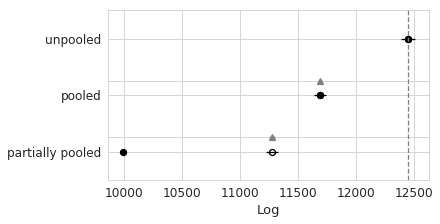

In [56]:
az.plot_compare(compare_df)

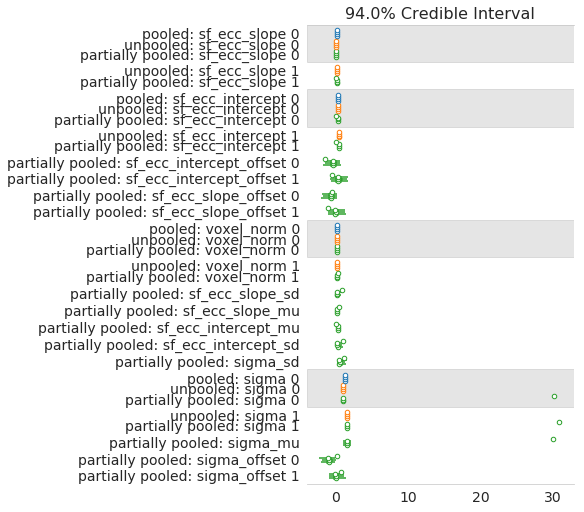

In [57]:
az.plot_forest(list(model_fits.values()), model_names=list(model_fits.keys()), combined=False, figsize=(8,7));

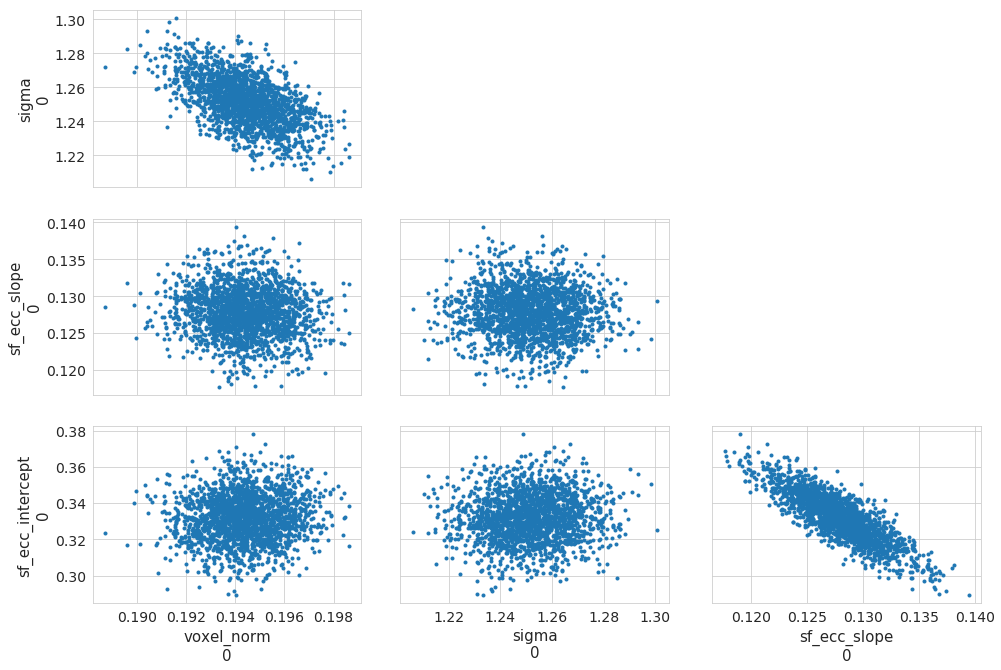

In [44]:
az.plot_pair(model_fits['pooled']);

In [58]:
az.summary(inference_data)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
sigma_offset[0],-0.71,0.70,0.20,-1.86,0.16,3.0,1.49
sigma_offset[1],0.23,0.59,0.11,-0.94,1.08,9.0,1.16
sf_ecc_slope_offset[0],-0.67,0.49,0.03,-1.70,0.20,463.0,1.02
sf_ecc_slope_offset[1],-0.22,0.72,0.18,-1.03,1.26,4.0,1.34
sf_ecc_intercept_offset[0],-0.72,0.71,0.19,-1.72,0.39,4.0,1.39
sf_ecc_intercept_offset[1],0.18,0.69,0.16,-0.65,1.58,6.0,1.25
voxel_norm[0],0.20,0.03,0.01,0.14,0.22,2.0,19.61
voxel_norm[1],0.21,0.04,0.01,0.19,0.28,2.0,20.39
sigma_mu,8.65,12.30,4.92,1.03,30.06,2.0,48.89
sigma_sd,0.79,0.42,0.09,0.12,1.30,6.0,1.24


In [ ]:
az.plot_trace(inference_data);

In [357]:
az.compare(model_fits, scale='log')

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
partially pooled,12379.9,0.481644,0,0.492266,53.724,0,0,log
unpooled,12379.9,0.480563,0.0131429,0.507734,53.7237,0.0228877,0,log
pooled,11681.4,1.25819,698.491,0,51.2934,13.6452,0,log


In [358]:
az.compare(model_fits, 'loo', scale='log')

,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
partially pooled,12379.9,0.48165,0,0.492267,53.724,0,0,log
unpooled,12379.9,0.48057,0.0131437,0.507733,53.7237,0.0228874,0,log
pooled,11681.4,1.25819,698.491,0,51.2934,13.6452,0,log


In [361]:
inference_data.posterior

<xarray.Dataset>
Dimensions:                 (chain: 4, draw: 500, sf_ecc_intercept_dim_0: 2, sf_ecc_slope_dim_0: 2, sigma_dim_0: 2, voxel_norm_dim_0: 2)
Coordinates:
  * chain                   (chain) int64 0 1 2 3
  * draw                    (draw) int64 0 1 2 3 4 5 ... 494 495 496 497 498 499
  * voxel_norm_dim_0        (voxel_norm_dim_0) int64 0 1
  * sigma_dim_0             (sigma_dim_0) int64 0 1
  * sf_ecc_slope_dim_0      (sf_ecc_slope_dim_0) int64 0 1
  * sf_ecc_intercept_dim_0  (sf_ecc_intercept_dim_0) int64 0 1
Data variables:
    voxel_norm              (chain, draw, voxel_norm_dim_0) float64 0.2177 ... 0.1917
    sigma_mu                (chain, draw) float64 1.642 1.377 ... 1.695 1.603
    sigma_sd                (chain, draw) float64 0.3325 0.3253 ... 0.4066
    sigma                   (chain, draw, sigma_dim_0) float64 1.001 ... 1.519
    sf_ecc_slope_mu         (chain, draw) float64 0.2036 0.2462 ... 0.1584
    sf_ecc_slope_sd         (chain, draw) float64 0.1129 0.118

# Actual results

## First attempt

It worked with the `advi+adapt_diag` initialization, but not with `adapt_diag` or `jitter+adapt_diag`

In [363]:
inference_data_1 = az.load_data('/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial/sub-wlsubj001/ses-01/sub-wlsubj001_ses-01_task-sfp_v1_e1-12_summary_s500_c8_i-advi+adapt_diag_ntarget_accept=.9_mcmc.nc')
inference_data_2 = az.load_data('/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary_s500_c8_i-advi+adapt_diag_ntarget_accept=.9_mcmc.nc')

In [366]:
inference_data_jt = az.load_data("/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial_multisubj/v1_e1-12_s500_c8_i-advi+adapt_diag_ntarget_accept=.9_unpooled_mcmc.nc")

In [74]:
az.summary(inference_data_1)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm,0.16,0.0,0.0,0.16,0.16,2319.0,1.0
sigma,2.37,0.0,0.0,2.37,2.38,2285.0,1.0
sf_ecc_slope,0.13,0.0,0.0,0.12,0.13,1795.0,1.0
sf_ecc_intercept,0.36,0.0,0.0,0.35,0.36,1899.0,1.0


In [75]:
az.summary(inference_data_2)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm,0.17,0.0,0.0,0.17,0.17,2944.0,1.0
sigma,1.93,0.0,0.0,1.93,1.93,2123.0,1.0
sf_ecc_slope,0.14,0.0,0.0,0.14,0.14,1916.0,1.0
sf_ecc_intercept,0.19,0.0,0.0,0.19,0.19,1941.0,1.0


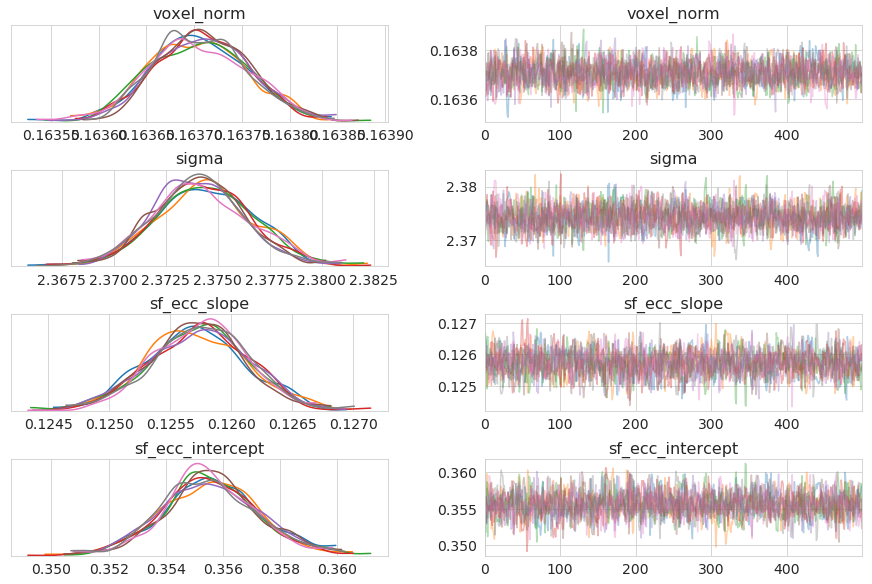

In [76]:
az.plot_trace(inference_data_1);

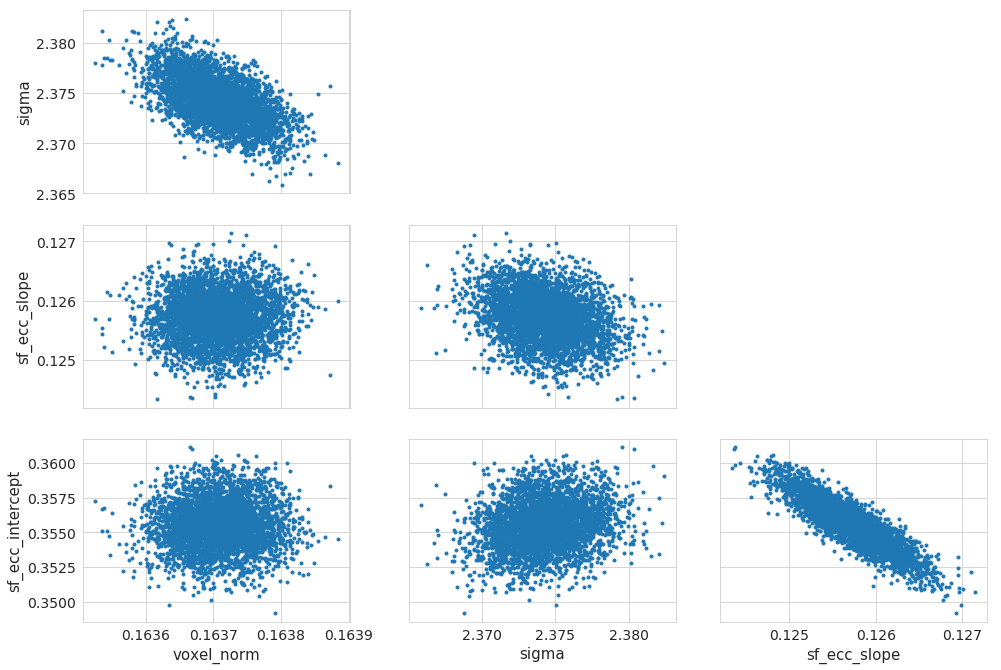

In [77]:
az.plot_pair(inference_data_1);

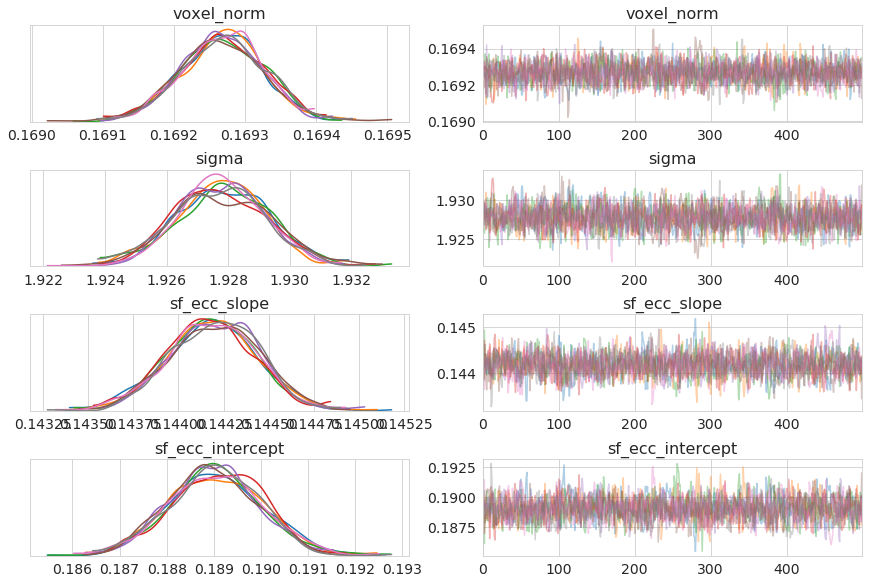

In [78]:
az.plot_trace(inference_data_2);

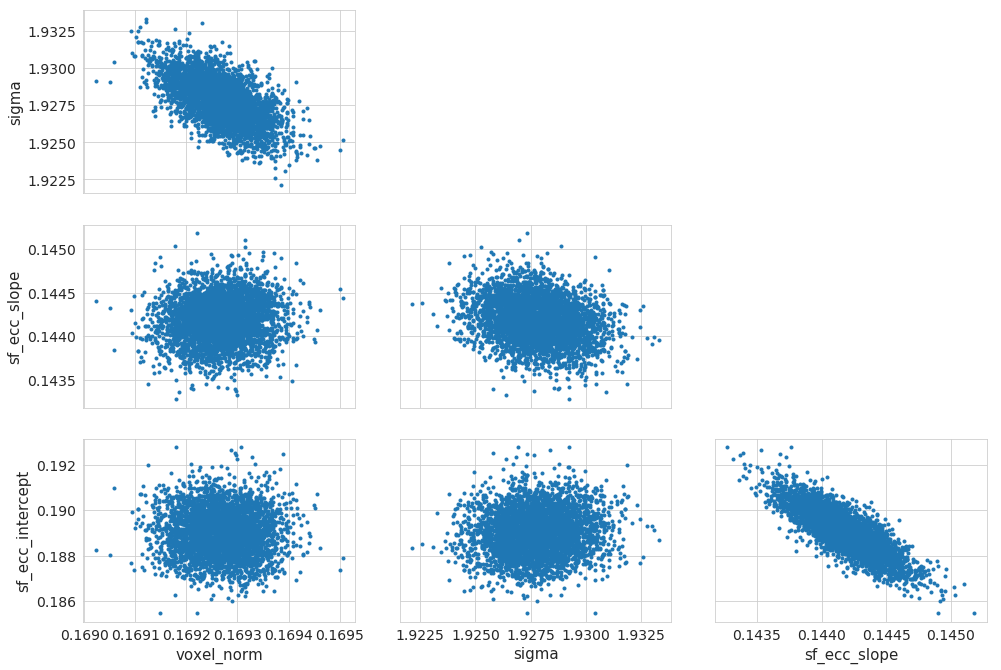

In [79]:
az.plot_pair(inference_data_2);

# Fitting everything with Metropolis-Hastings

This is ugly (because it's MH) and, because we have so many observations (~100k voxels across the 7 subjects), the `InferenceData` object ends up being very large. So we grab only the last 100 steps, which have basically converged, to examine what's going on.

Okay

In [16]:
model_fits = {}

In [2]:
df_path_template = '/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/{subject}/{session}/{subject}_{session}_{task}_v1_e1-12_summary.csv'
identity_list = [['sub-wlsubj001', 'ses-01', 'task-sfp'],
                 ['sub-wlsubj042', 'ses-02', 'task-sfp'],
                 ['sub-wlsubj045', 'ses-03', 'task-sfp'],
                 ['sub-wlsubj004', 'ses-03', 'task-sfp'],
                 ['sub-wlsubj014', 'ses-03', 'task-sfp'],
                 ['sub-wlsubj045', 'ses-04', 'task-sfprescaled'],
                 ['sub-wlsubj064', 'ses-04', 'task-sfprescaled'],
                ]
df = []
for subj, ses, t in identity_list:
    path = df_path_template.format(subject=subj, session=ses, task=t)
    tmp = pd.read_csv(path)
    if 'first_level_analysis' in path:
        tmp['session'] = path.split(os.sep)[-2]
        tmp['subject'] = path.split(os.sep)[-3]
        tmp['task'] = re.search('_(task-[a-z0-9]+)_', path).groups()[0]
        tmp['indicator'] = tmp.apply(lambda x: str((x.subject, x.session, x.task)), 1)
    df.append(tmp)
df = pd.concat(df)
df_filter = sfp.model.construct_df_filter('drop_voxels_with_negative_amplitudes,drop_voxels_near_border')
df = df_filter(df)

In [102]:
df_filter = sfp.model.construct_df_filter('drop_voxels_with_negative_amplitudes,drop_voxels_near_border,randomly_reduce_num_voxels:200')

In [59]:
voxels = np.random.choice(tmp.voxel.unique(), 200, replace=False)

In [67]:
tmp.query('voxel in @voxels').

200

In [212]:
model_fits = {}

In [221]:
hierarchy_type = 'partially-pooled'
db_path = '/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial_multisubj/v1_e1-12_s1000_c8_i-None_nNone_%s_Metropolis_mcmc' % hierarchy_type
db_path = '/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial_multisubj/v1_e1-12_s1000_c8_i-advi+adapt_diag_ntarget_accept=.9_%s_NUTS_mcmc' % hierarchy_type

In [222]:
data = az.from_netcdf(db_path+'.nc')

In [223]:
data.posterior = data.posterior.rename({'sigma': r'$\sigma$', 'sf_ecc_slope': r'$a$', 'sf_ecc_intercept': r'$b$',
                                        'sigma_mu': r'$\mu_\sigma$', 'sigma_sd': r'$\sigma_\sigma$',
                                        'sf_ecc_slope_mu': r'$\mu_a$', 'sf_ecc_slope_sd': r'$\sigma_a$', 
                                        'sf_ecc_intercept_mu': r'$\mu_b$', 'sf_ecc_intercept_sd': r'$\sigma_b$'})

In [135]:
# data.posterior = data.posterior.sel({'chain': [0, 4, 6,7]})

In [224]:
model_fits[hierarchy_type] = data

In [117]:
compare_df = az.compare(model_fits, 'loo', scale='log')
compare_df

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/stats/stats.py:454: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
unpooled,110174,88.4576,0,0.333333,483.163,0,0,log
pooled,104569,17.3959,5604.83,0.333333,507.503,191.948,0,log
partially-pooled,-1.43526e+06,1.53006e+06,1.54543e+06,0.333333,8613.66,8544.45,1,log


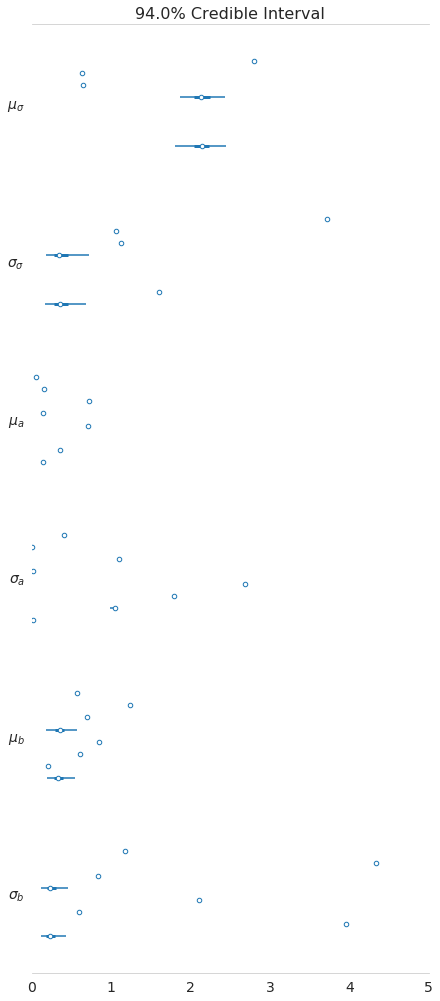

In [225]:
fig, axes = az.plot_forest(model_fits['partially-pooled'], var_names=[r'$\mu_\sigma$', r'$\sigma_\sigma$', r'$\mu_a$', r'$\sigma_a$', r'$\mu_b$', r'$\sigma_b$'], combined=False)
for ax in axes:
    ax.set_xlim((0,5))

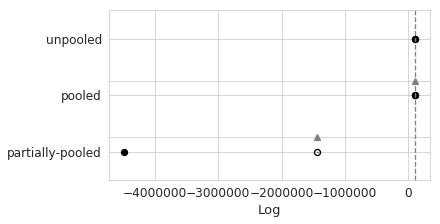

In [118]:
az.plot_compare(compare_df)

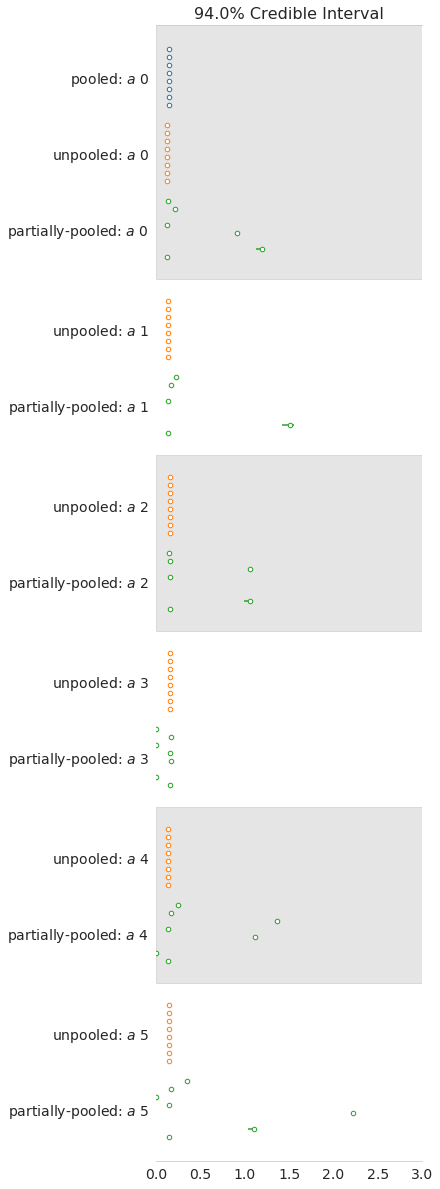

In [227]:
fig, axes = az.plot_forest(list(model_fits.values()), model_names=list(model_fits.keys()), combined=False, var_names=[r'$a$'])
for ax in axes:
    ax.set_xlim((0, 3))

(<Figure size 432x1180.8 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b6d9fd198>],
       dtype=object))

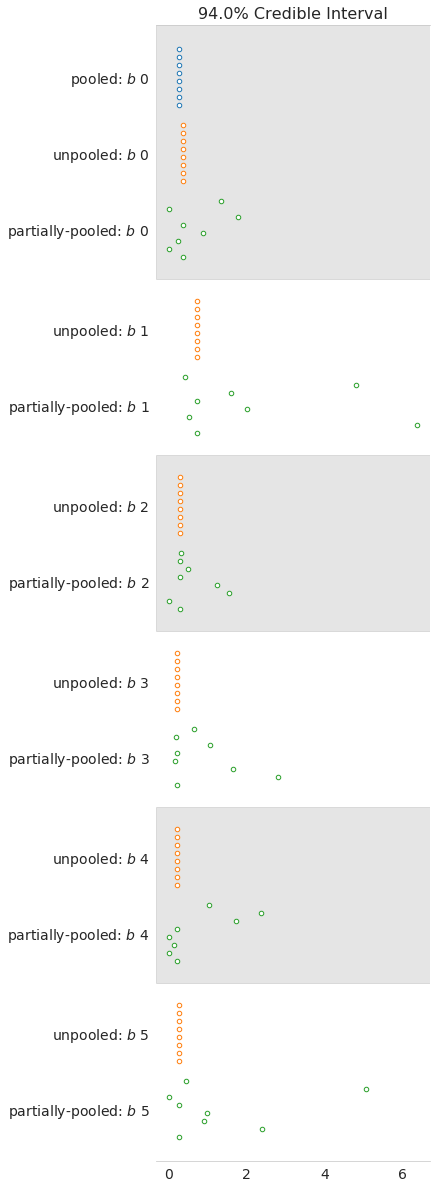

In [228]:
az.plot_forest(list(model_fits.values()), model_names=list(model_fits.keys()), combined=False, var_names=[r'$b$'])

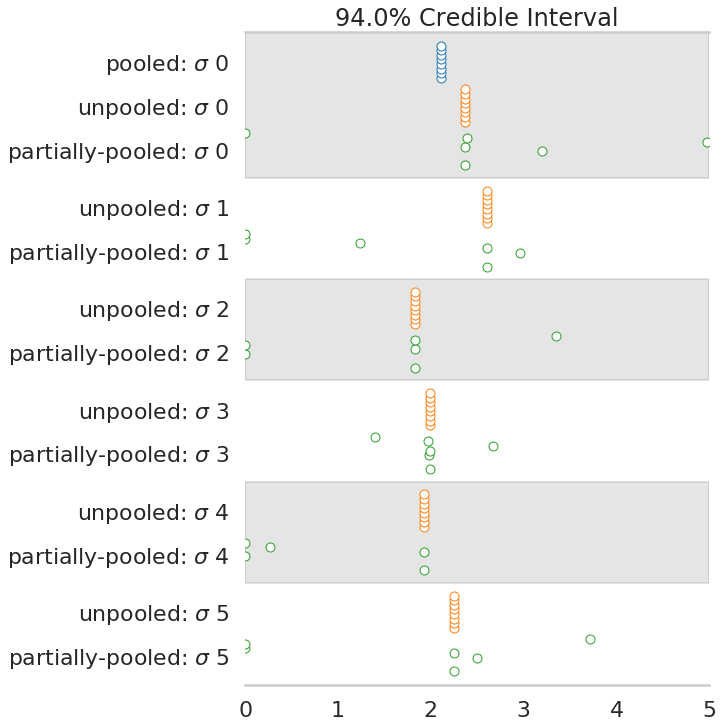

In [232]:
with sns.plotting_context('poster'):
    fig, axes = az.plot_forest(list(model_fits.values()), model_names=list(model_fits.keys()), combined=False, var_names=[r'$\sigma$'], figsize=(10,10),)
    for ax in axes:
        ax.set_xlim((0,5))

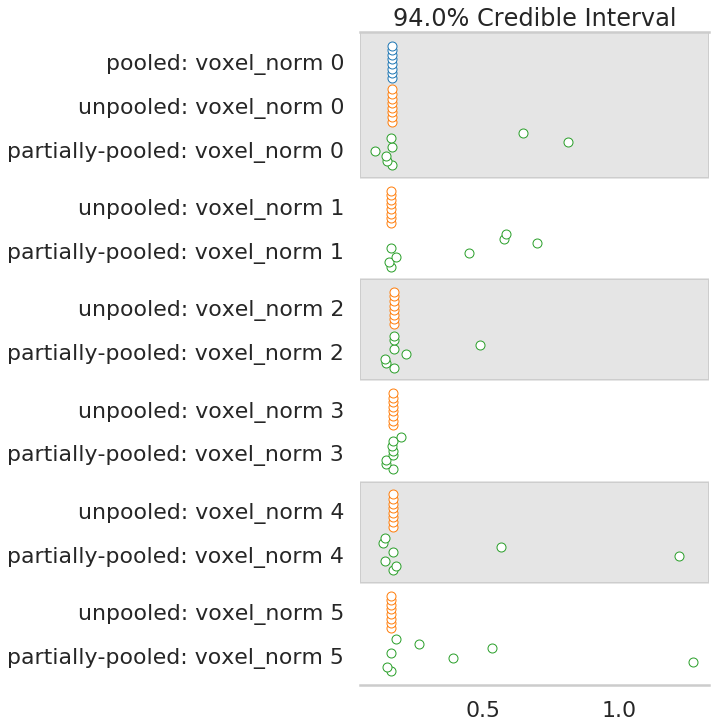

In [159]:
with sns.plotting_context('poster'):
    az.plot_forest(list(model_fits.values()), model_names=list(model_fits.keys()), combined=False, var_names=['voxel_norm'], figsize=(10,10))

In [28]:
model = sfp.monte_carlo.setup_model(df, hierarchy_type=hierarchy_type.replace('-', ' '))
with model:
    trace = pm.backends.text.load(db_path)

Started with 24681 voxels, after filtering with df_filter_string None have 24681 voxels
Will fit partially pooled model, parameters for all 7 sessions share hyperparams!


In [48]:
np.random.choice(df.voxel.unique(), 100, replace=False)

array([1280, 4946, 1685, 4416, 3315, 3565, 2910, 4390, 5312, 5026, 1962,
       3820, 3946, 3293, 5267, 1345, 1872, 2085, 3060, 4524,  553, 5042,
       4457, 2827, 5574, 5126, 4591, 2902, 5038,  775, 4435, 3897, 3434,
       2535, 2323,  737, 5404, 5597, 1904, 1832,  949, 3084, 4493, 1859,
        634, 4313, 2504, 1079, 2420,  178, 5591, 3265, 2182, 3063, 1898,
       4098,  510, 4029, 1971, 4582, 4125, 4122, 4148, 2451, 5677, 3580,
       1748, 3876, 4381, 2828, 3485,  107, 3176, 4692, 1389, 4354,  366,
       1442, 4978, 1010,  133, 5339, 2356, 5192, 5088, 2618, 4019,  898,
        407, 5540, 1821, 2294, 4851, 1433,  861, 2874, 1799, 2520, 5155,
        847])

In [44]:
df.query('voxel<400').groupby(['indicator']).size() / 48

indicator
('sub-wlsubj001', 'ses-01', 'task-sfp')            371.0
('sub-wlsubj004', 'ses-03', 'task-sfp')            342.0
('sub-wlsubj014', 'ses-03', 'task-sfp')            239.0
('sub-wlsubj042', 'ses-02', 'task-sfp')            188.0
('sub-wlsubj045', 'ses-03', 'task-sfp')            357.0
('sub-wlsubj045', 'ses-04', 'task-sfprescaled')    325.0
('sub-wlsubj064', 'ses-04', 'task-sfprescaled')    315.0
dtype: float64

In [33]:
len(df)

1184688

In [7]:
az.plot_trace(data)

ValueError: cannot convert float NaN to integer

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f51089e7bf8> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f51089f4620> (for post_execute):


KeyboardInterrupt: 

In [31]:
pm.summary(trace[-3000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma_offset__0,0.556617,2.404384,0.238129,-3.837008e+00,3.651484,4.037275,12.653186
sigma_offset__1,3.938345,5.717438,0.570969,-2.139392e+00,15.143630,4.013901,21.969771
sigma_offset__2,2.457973,5.445728,0.542584,-1.669865e+00,16.806055,4.097432,7.929277
sigma_offset__3,4.628945,7.166172,0.715654,-4.642405e+00,16.802929,4.002315,63.352443
sigma_offset__4,1.298735,3.130780,0.310023,-3.000996e+00,6.285184,4.015589,18.581513
sigma_offset__5,1.814393,4.167076,0.412208,-4.000444e+00,11.158536,4.082107,8.593150
sigma_offset__6,3.364985,6.629826,0.661165,-2.882213e+00,17.299173,4.013728,22.227868
sf_ecc_slope_offset__0,0.182135,1.659420,0.162332,-1.794831e+00,3.388708,4.271801,4.472579
sf_ecc_slope_offset__1,19.273220,36.165101,3.588936,-1.232661e+00,111.926660,4.003536,45.098479
sf_ecc_slope_offset__2,52.095578,130.567945,12.907632,-1.222414e+01,396.736618,4.000765,243.186215


In [21]:
pm.summary(trace[-100:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
voxel_norm__0,0.708077,1.011629,0.100924,1.436203e-01,3.049305,4.020101,3961.667680
voxel_norm__1,0.360951,1.533584,0.151147,-3.344670e+00,1.902417,4.020101,2599.704876
voxel_norm__2,-0.001069,1.253610,0.123783,-1.969963e+00,2.739774,4.020101,4493.852314
voxel_norm__3,-0.036215,0.420855,0.041575,-1.131868e+00,0.162183,4.020102,1659.952724
voxel_norm__4,0.040247,0.837145,0.082863,-1.923174e+00,1.336933,4.020109,891.066384
voxel_norm__5,0.532107,0.932753,0.092554,-1.117510e+00,2.037399,4.020102,2315.870107
voxel_norm__6,1.062017,1.372452,0.135262,8.983902e-03,4.124537,4.020102,2052.741775
sigma__0,10.537060,23.318647,2.304602,7.843280e-03,72.253095,4.020610,115.963191
sigma__1,4.273369,5.254716,0.519970,8.092233e-03,14.880612,4.020114,633.747511
sigma__2,7.867909,12.721730,1.255258,1.198156e-03,38.630810,4.020231,216.963416


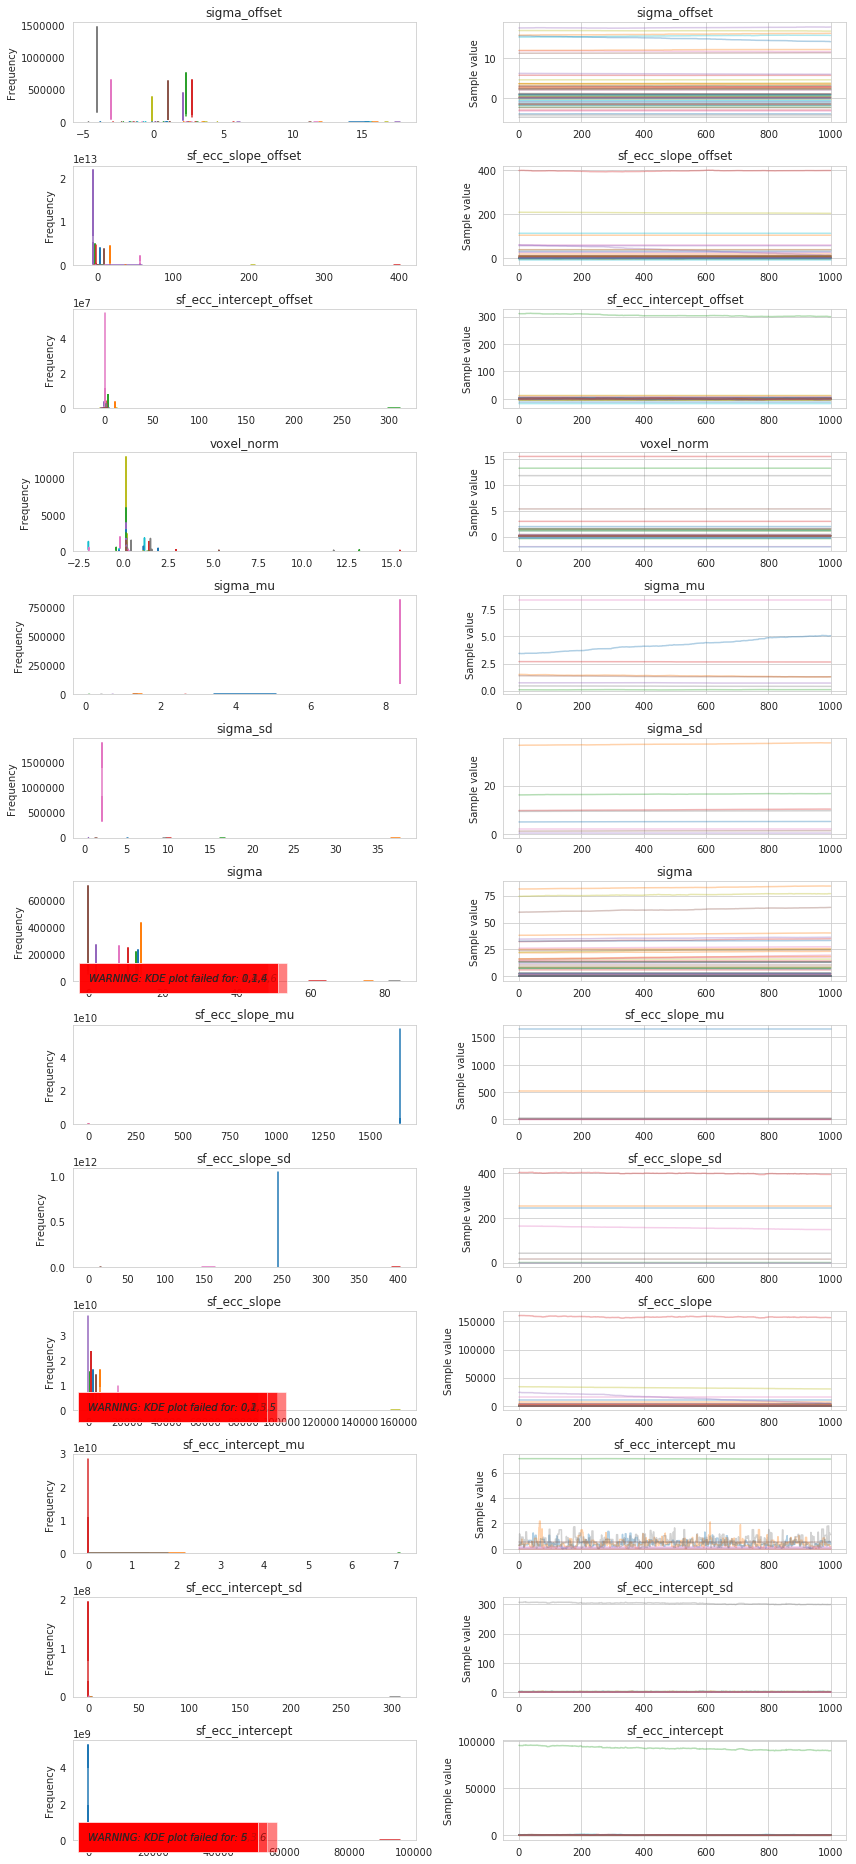

In [30]:
pm.traceplot(trace[-1000:]);

In [13]:
data= az.from_pymc3(trace[-100:])

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


In [14]:
data.to_netcdf(db_path+'.nc')

'/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial_multisubj/v1_e1-12_s3000_c8_i-None_nNone_pooled_Metropolis_mcmc.nc'

In [17]:
model_fits[hierarchy_type] = data

In [55]:
compare_df = az.compare(model_fits, scale='log')
compare_df

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
unpooled,12450.5,0.378008,0,1,58.1663,0,0,log
pooled,11689.7,1.35831,760.783,0,55.2542,14.7149,0,log
partially pooled,11276.3,644.124,1174.24,0,53.8987,26.6823,1,log


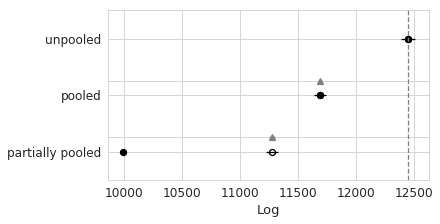

In [56]:
az.plot_compare(compare_df)

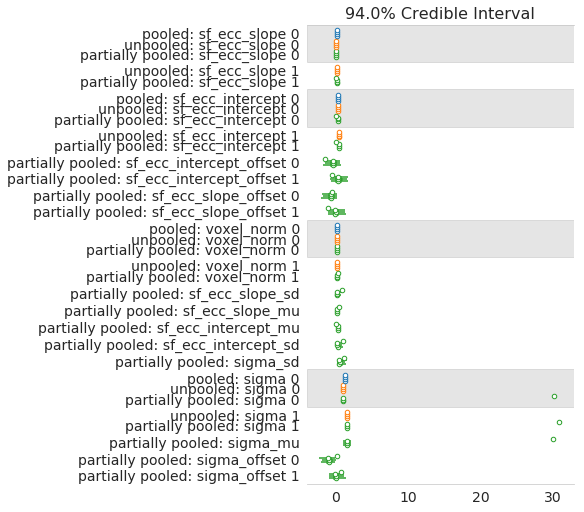

In [57]:
az.plot_forest(list(model_fits.values()), model_names=list(model_fits.keys()), combined=True, figsize=(8,7));